In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

# DeltagonalShift Testing Suite

## Variable Meanings

A - the initial matrix <br>
l - number of iterations for one trace/diagonal estimator <br>
m - number of iterations of matrix pertubation <br>
pertube_std - the standard deviation of the normal distribution matrix added

In [4]:
# Matrix generators
def generate_rademacher(size):
    return np.random.choice([-1, 1], size=(size, ))

def generate_matrix(size):
    result = np.random.rand(size, size) 
    norm = np.linalg.norm(result, 'fro')
    return result / norm

def pertube_matrix(A, pertube_std=0.1):
    return A + np.random.normal(0, pertube_std, size=A.shape)

In [5]:
# Hutchinson's Trace Estimator
def trace_estimator(A, l):
    size = A.shape[0]
    result = 0
    for _ in range(l):
        g_vec = np.random.normal(0, 1, size=(size, ))
        result += np.dot(np.transpose(g_vec), np.dot(A, g_vec))
    result = result / l

    return result

In [6]:
# Hutchinson's Diagonal Estimator 
def diagonal_estimator(A, l):
    size = A.shape[0]
    result = np.zeros((size, 1))
    for _ in range(l):
        rademacher = np.random.choice([-1, 1], size=(size, 1))
        # Multiplication between rademacher and A, then do hadamard product with rademacher
        result += np.multiply(rademacher, (np.matmul(A, rademacher)))
    result  = result / l
    result = np.reshape(result, (size, ))

    return result

In [7]:
# Repeated Hutchinson Trace Estimator
def repeated_trace_estimator(A, m, l, pertube_std):
    matrix_set = [A]
    result = [A]

    for _ in range(m):
        A = pertube_matrix(A, pertube_std)
        result.append(trace_estimator(A, l))
    return result

In [8]:
# Repeated Hutchinson Diagonal Estimator
def repeated_diagonal_estimator(A, m, l, pertube_std):
    matrix_set = [A]
    result = [diagonal_estimator(A, l)]  

    for _ in range(1, m):
        A = pertube_matrix(A, pertube_std)
        matrix_set.append(A)
        result.append(diagonal_estimator(A, l))

    return result, matrix_set

In [9]:
def deltashift(A, m, l0, l, gamma, pertube_std):
    t_prev = trace_estimator(A, l0)[0]
    result = [t_prev]
    matrix_set = [A]
    prev_matrix = A

    for _ in range(1, m):
        curr_matrix = pertube_matrix(prev_matrix, pertube_std)

        g = np.array([generate_rademacher(A.shape[0]) for _ in range(l)]) 
        z = np.array([np.matmul(prev_matrix, g[i]) for i in range(l)])
        w = np.array([np.matmul(curr_matrix, g[i]) for i in range(l)])

        right_sum = 0
        for i in range(l):
            right_sum += np.dot(g[i], w[i] - (1 - gamma) * z[i])
        right_sum /= l

        t_curr = (1 - gamma) * t_prev + right_sum
        prev_matrix = curr_matrix

        result.append(t_curr)
        matrix_set.append(curr_matrix)

        t_prev = t_curr
    return result, matrix_set

In [10]:
# DeltagonalShift 
def deltagonalshift(A, l0, m, l, gamma, pertube_std):
    d_prev = diagonal_estimator(A, l0)[0]
    result = [d_prev]
    matrix_set = [A]
    prev_matrix = A

    for _ in range(1, m):
        # create l random +1/-1 vectors 
        curr_matrix = pertube_matrix(prev_matrix, pertube_std)
        g = np.array([generate_rademacher(A.shape[0]) for _ in range(l)])

        right_sum = np.zeros((A.shape[0], ))
        for i in range(l):
            delta = np.matmul(curr_matrix, g[i]) - np.matmul((1 - gamma) * curr_matrix, g[i])
            right_sum += g[i] * delta
        right_sum /= l

        d_curr = (1 - gamma) * d_prev + right_sum 
        prev_matrix = curr_matrix

        result.append(d_curr)
        matrix_set.append(curr_matrix)
        d_prev = d_curr
    
    return result, matrix_set

# Testing Suite

l0 - initial set up via hutchinsons estimator for deltagonalshift <br>
la - number of iterations for the repeated diagonal estimator <br>
lb - number of iterations for deltagonashift <br>

Q - number of matvecs total

q = l0 + 2 * lb * (m - 1) = la * m 

For the error function, you have a set of the original matrices that are returned and the set of diagonal estimations that you receive; the error function will take your set of matrices, get the exact diagonals for each, and then find the average of the l2 norms for each vector pair; the error may not start off in the same place since it isn't cumulative. 

In [11]:
# calculate the error between two diagonals - not using the max diagonal fro
def calculate_error(predicted, actual):
    return np.linalg.norm(predicted - actual) / np.linalg.norm(actual)

In [18]:
# l2 used because the frobenius norm doesn't work for vectors

def repeated_diagonal_test(A, m, l, pertube_std):
    cumulative_error = [0 for _ in range(m)]
    avg_repdiag_time = 0
    for _ in range(50):
        start_time = time.time()
        repdiag_result, repdiag_matrix_set = repeated_diagonal_estimator(A, m, l, pertube_std)
        end_time = time.time()
        repdiag_true = [np.diag(repdiag_matrix_set[i]) for i in range(len(repdiag_matrix_set))]
        cumulative_error = [cumulative_error[i] + calculate_error(repdiag_result[i], repdiag_true[i]) for i in range(m)]
        avg_repdiag_time += (end_time - start_time)

    avg_repdiag_time /= 50
    print("Average Repeated Diagonal Time: " + str(avg_repdiag_time))
    cumulative_error = [cumulative_error[i] / 50 for i in range(m)]
    avg_error = sum(cumulative_error) / m
    print("Average Repeated Diagonal Error: " + str(avg_error)) 
    return cumulative_error

def deltagonalshift_test(A, l0, m, l, gamma, pertube_std):
    cumulative_error = [0 for _ in range(m)]
    avg_deltagonal_time = 0
    for _ in range(50):
        start_time = time.time()
        deltagonal_result, deltagonal_matrix_set = deltagonalshift(A, l0, m, l, gamma, pertube_std) 
        end_time = time.time()
        deltagonal_true = [np.diag(deltagonal_matrix_set[i]) for i in range(len(deltagonal_matrix_set))]
        avg_deltagonal_time += (end_time - start_time)
        cumulative_error = [cumulative_error[i] + calculate_error(deltagonal_result[i], deltagonal_true[i]) for i in range(m)]

    avg_deltagonal_time /= 50
    print("Average Deltagonal Time: " + str(avg_deltagonal_time))
    cumulative_error = [cumulative_error[i] / 50 for i in range(m)]
    avg_error = sum(cumulative_error) / m
    print("Average Deltagonal Error: " + str(avg_error))
    return cumulative_error

In [19]:
def plot_error(repeated_diagonal, deltagonalshift, title):
    plt.plot(repeated_diagonal, label="Repeated Diagonal")
    plt.plot(deltagonalshift, label="DeltagonalShift")
    plt.title(title)
    plt.xlabel("Matrix Timesteps")
    plt.ylabel("|Diag(A_i) - D_i|_2 / Diag(A_i)_2")
    plt.legend()
    plt.show()

In [22]:
def synthetic_test(pertube_std, gamma, dim):
    A = generate_matrix(dim)
    m = 100
    l0 = 10
    la = 10
    lb = 5
    m = 100

    repdiag_error = repeated_diagonal_test(A, m, la, pertube_std)
    deltagonalshift_error = deltagonalshift_test(A, l0, m, lb, gamma, pertube_std)
    plot_error(repdiag_error, deltagonalshift_error, "Repeated Diagonal Estimator vs. Deltagonalshift, Pertubation = " + str(pertube_std) + ", Gamma = " + str(gamma) + ", Dim = " + str(dim))

# don't set l0 or l since they will differ between repeated diagonals and deltagonalshift

Average Repeated Diagonal Time: 0.02177022933959961
Average Repeated Diagonal Error: 1.0495847662872375
Average Deltagonal Time: 0.012590436935424805
Average Deltagonal Error: 0.4159096327528672


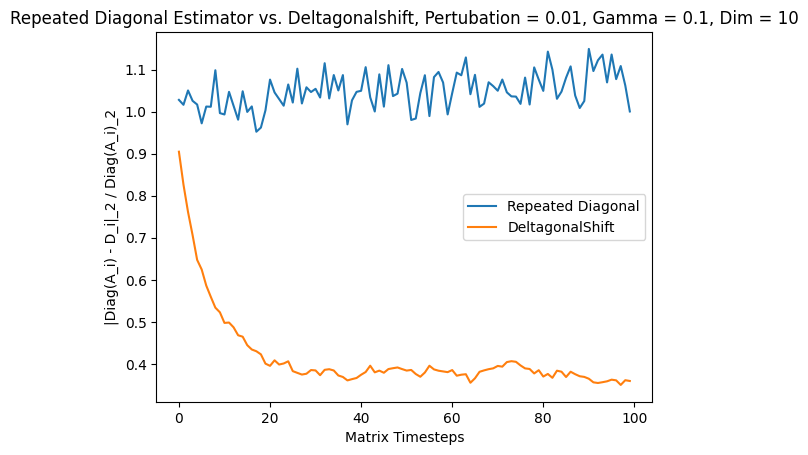

Average Repeated Diagonal Time: 0.02127040386199951
Average Repeated Diagonal Error: 0.970345080099435
Average Deltagonal Time: 0.012300286293029785
Average Deltagonal Error: 0.48603102351535526


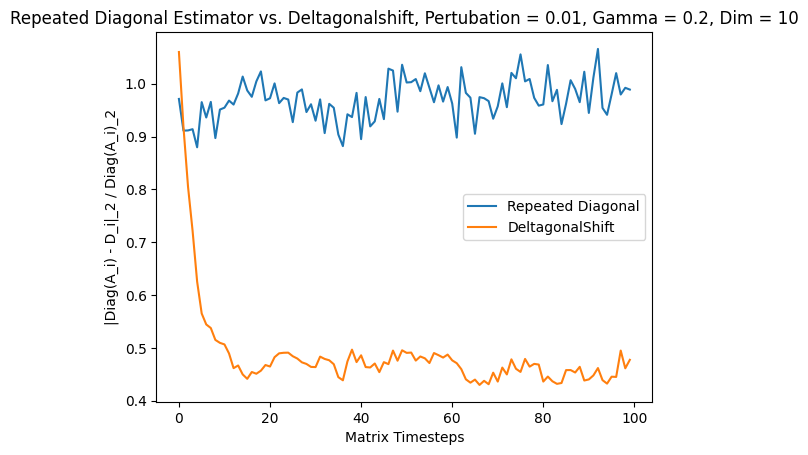

Average Repeated Diagonal Time: 0.021500883102416993
Average Repeated Diagonal Error: 0.8133944671063265
Average Deltagonal Time: 0.012290301322937012
Average Deltagonal Error: 0.49022677262295744


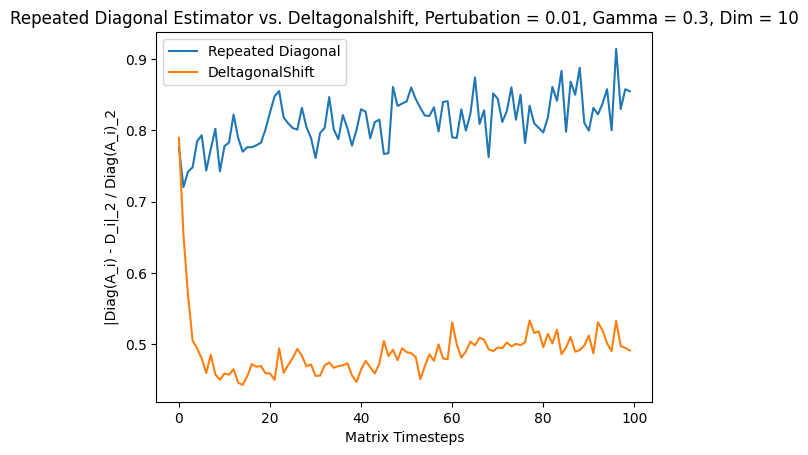

Average Repeated Diagonal Time: 0.021410012245178224
Average Repeated Diagonal Error: 0.861352672510672
Average Deltagonal Time: 0.012361392974853516
Average Deltagonal Error: 0.655453968466858


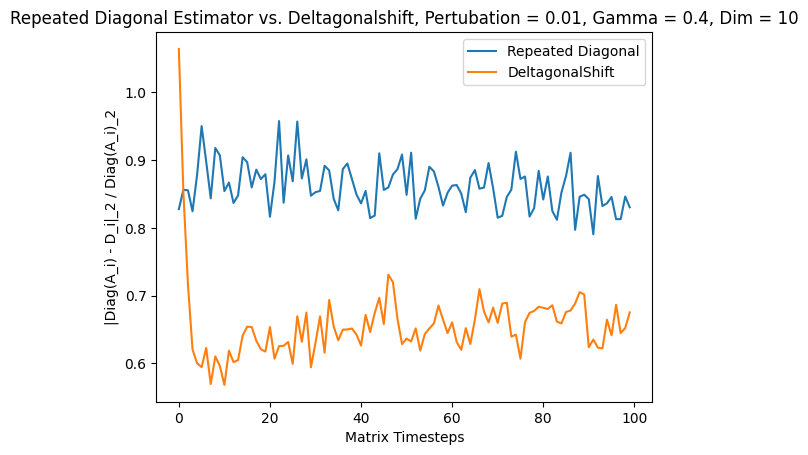

Average Repeated Diagonal Time: 0.02179525375366211
Average Repeated Diagonal Error: 0.9497254241868128
Average Deltagonal Time: 0.012411184310913086
Average Deltagonal Error: 0.8085026135564


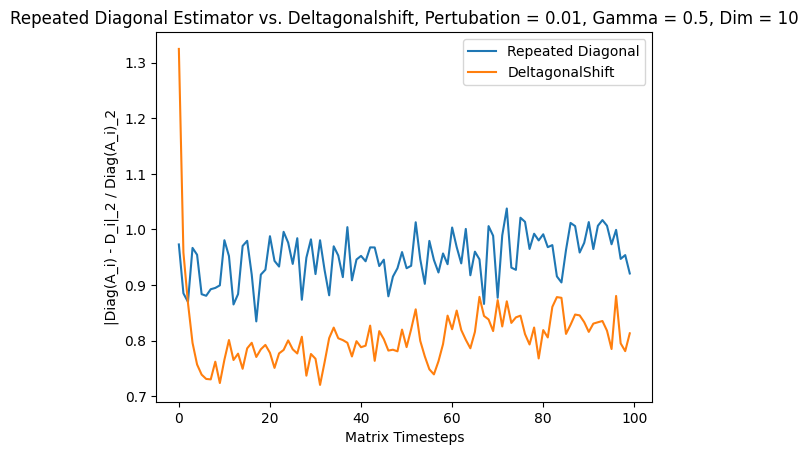

Average Repeated Diagonal Time: 0.02166112422943115
Average Repeated Diagonal Error: 0.9768024880217314
Average Deltagonal Time: 0.012440781593322753
Average Deltagonal Error: 0.45615609199675966


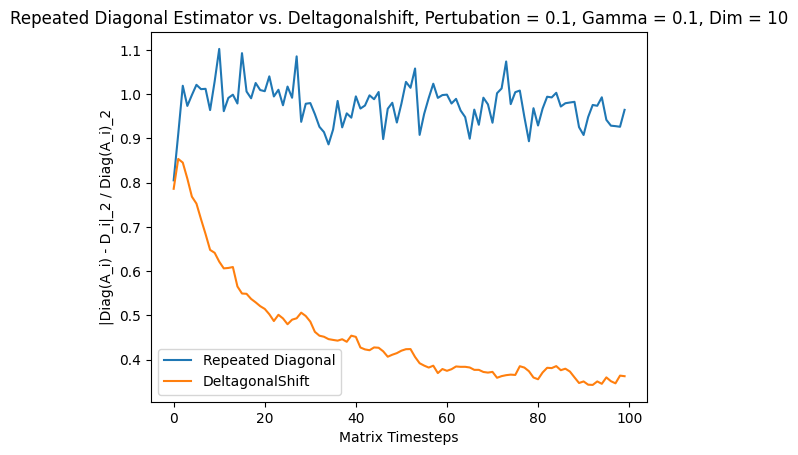

Average Repeated Diagonal Time: 0.021489853858947753
Average Repeated Diagonal Error: 1.0166593760851015
Average Deltagonal Time: 0.012440042495727539
Average Deltagonal Error: 0.5370227501079669


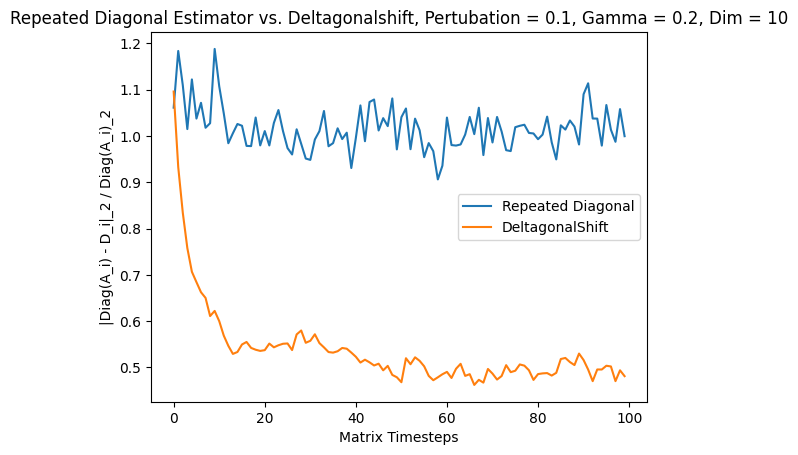

Average Repeated Diagonal Time: 0.021520662307739257
Average Repeated Diagonal Error: 0.9936518174846743
Average Deltagonal Time: 0.012559728622436523
Average Deltagonal Error: 0.6050072084391731


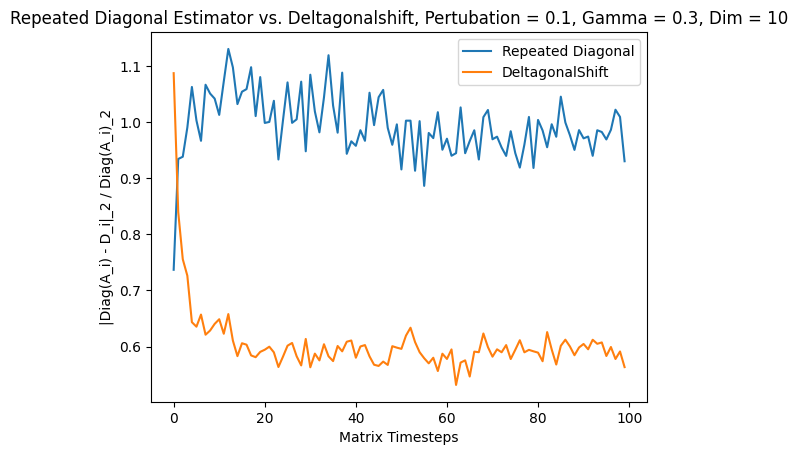

Average Repeated Diagonal Time: 0.02177156925201416
Average Repeated Diagonal Error: 0.9732809063516321
Average Deltagonal Time: 0.012200460433959961
Average Deltagonal Error: 0.7145372342957765


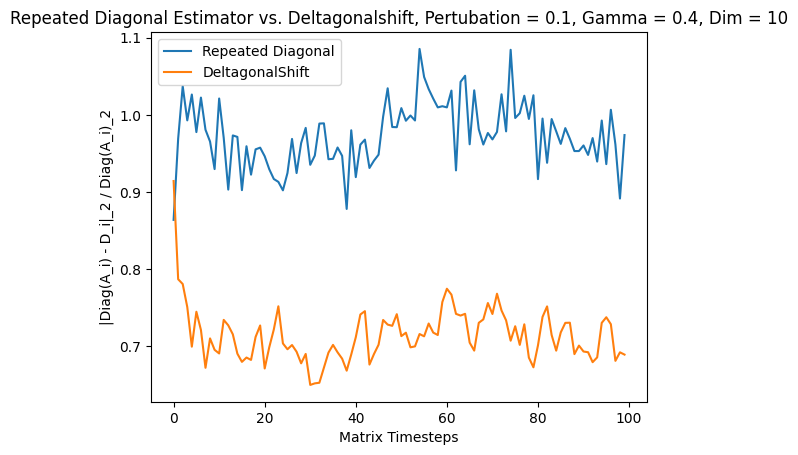

Average Repeated Diagonal Time: 0.021563720703125
Average Repeated Diagonal Error: 1.0416476523634979
Average Deltagonal Time: 0.01240084171295166
Average Deltagonal Error: 0.8711442237330211


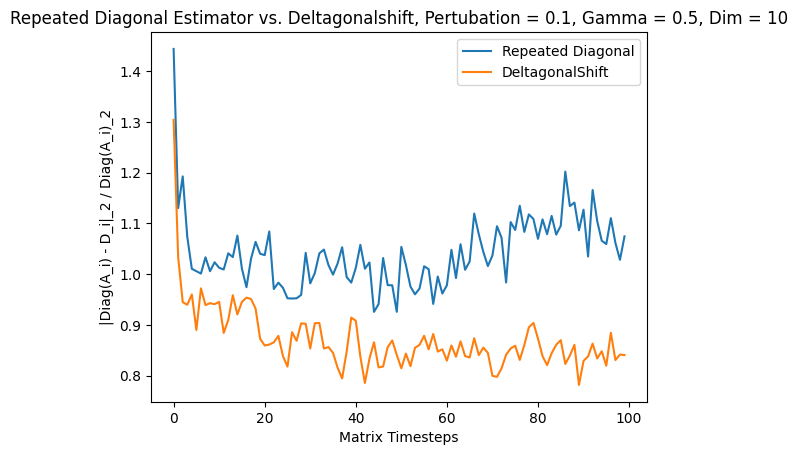

In [24]:
# Synthetic Tests

synthetic_test(0.01, 0.1, 10)
synthetic_test(0.01, 0.2, 10)
synthetic_test(0.01, 0.3, 10)
synthetic_test(0.01, 0.4, 10)
synthetic_test(0.01, 0.5, 10)

synthetic_test(0.1, 0.1, 10)
synthetic_test(0.1, 0.2, 10)
synthetic_test(0.1, 0.3, 10)
synthetic_test(0.1, 0.4, 10)
synthetic_test(0.1, 0.5, 10)